# Mean-Variance Optimization

In this notebook I implement the classical **mean-variance optimization** (MVO) algorithm that finds the optimal weights of a portfolio.     
For a theoretical background see [modern portfolio theory](https://en.wikipedia.org/wiki/Modern_portfolio_theory).


## Contents
   - [Loading data and parameter definition](#sec1) 
   - [Some mathematics](#sec2)
   - [Optimization with scipy.optimize](#sec3)
     - [Optimize the Sharpe ratio](#sec3.1)
     - [Optimal weights between stocks and bond](#sec3.2)
   - [Optimization with cvxpy](#sec4) 
   - [Probability density of the tangency portfolio](#sec5) 
   - [Short positions - closed formula](#sec6) 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy.stats as ss
import seaborn as sns
import warnings
from scipy.optimize import Bounds, LinearConstraint, minimize
from IPython.display import display
from FMNM.portfolio_optimization import optimal_weights

<a id='sec1'></a>
## Loading data and parameter definition

In the following I define the investment horizon of **1 month** and the risk free monthly return **Rf**.    
I also load the time series of daily prices from *filename*, and print the names of the stocks considered in the analysis. 

In [3]:
filename = "data/stocks_data.csv"
investment_horizon = 252 / 12  # 252 days / 12 months = 1 month
Rf = 0.01 / 12  # annual rate / 12 months

In [4]:
data = pd.read_csv(filename, index_col="Date", parse_dates=True)
stocks = data.columns
N = len(stocks)
print("There are NaNs") if data.isna().any(axis=1).any(axis=0) else print("There are NO NaNs")
pd.DataFrame(columns=stocks)

There are NO NaNs


,AAPL,AMZN,GOOGL,JPM,GLD,DIS,VNO,FB,UBS,KO,MCD,^GSPC,GM


Since the number of stocks is small, it could be useful to plot the normalized time series and the correlation matrix of the log-returns.

In [5]:
log_ret = np.log(data / data.shift())[1:]  # compute log-returns

#### plots

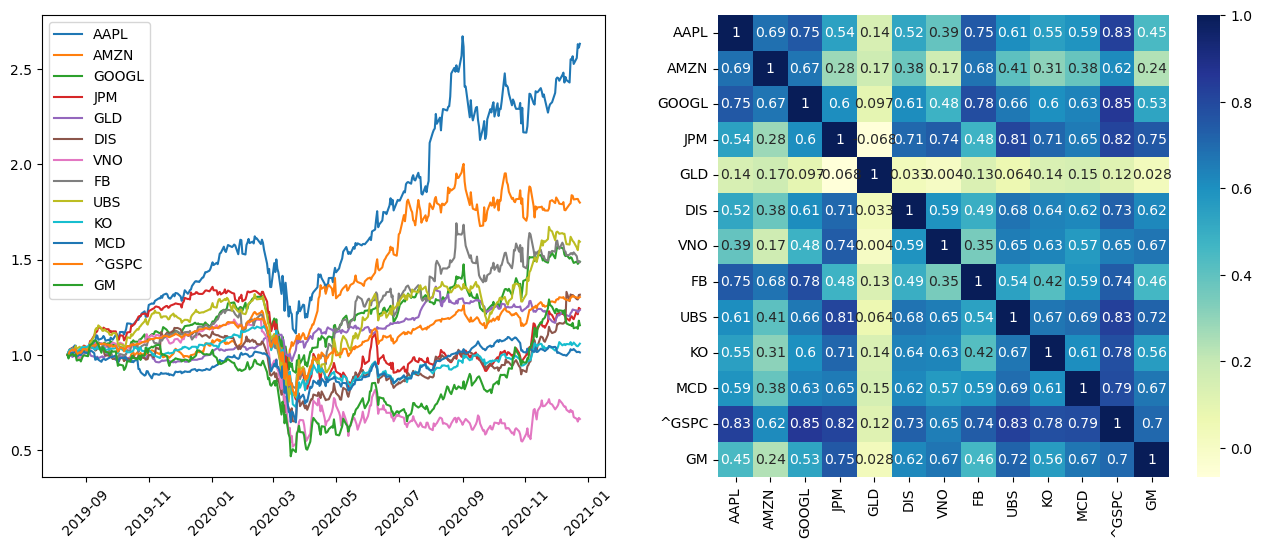

In [6]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for stk in stocks:
    ax1.plot(data[stk] / data[stk][0], label=stk)
ax1.legend()
ax1.xaxis.set_tick_params(rotation=45)
sns.heatmap(log_ret.corr(), annot=True, cmap="YlGnBu", ax=ax2)
plt.show()

<a id='sec2'></a>
## Some mathematics

Let us indicate the stock price at time $t$ with $S_t$.     
We can now recall some important definitions:

#### Log returns

$$ L_t := \log \frac{S_t}{S_{t-1}} $$

#### Linear returns

$$ R_t := \frac{S_t - S_{t-1}}{S_{t-1}} = \frac{S_t}{S_{t-1}} -1  $$

There are two important properties to remember:

1) Thanks to the properties of logarithms, for $t_0 = 0 < t_1 < ... < t_n = T$ we can write:

$$ 
\begin{aligned}
L_T &= \log \frac{S_T}{S_{0}} \\
&= \log \bigg( \frac{S_{t_1}}{S_{t_0}} \cdot \frac{S_{t_2}}{S_{t_1}} \cdot \frac{S_{t_3}}{S_{t_2}} ....\frac{S_{t_n}}{S_{t_{n-1}}} \bigg) \\
&= \log \frac{S_{t_1}}{S_{0}} + \log \frac{S_{t_2}}{S_{t_1}} + ... + \log \frac{S_{T}}{S_{t_{n-1}}} \\
&= \sum_{i=1}^n \log \frac{S_{t_{i}}}{S_{t_{i-1}}} = \sum_{i=1}^n L_{t_i}. 
\end{aligned}
$$

2) If we have a **portfolio** $P_t$ with $N$ stocks, we can prove that the linear return of the portfolio at time $t$ before rebalancing (with weights selected at time $t-1$) is:

$$ R_t^P = \sum_{i=1}^N w_{t-1}^i R_t^i $$

Let us consider an investor with a total capital $C$ in cash at time $t=0$.     
At time $t \geq 0$ he decides to buy $\alpha_t^i$ shares of the stock $S_t^i$. Of course the conditions 

$$ P_t = \sum_{i=1}^N \alpha_t^i \, S_t^i \quad \text{and} \quad P_0 = C $$

must hold. It convenient to define the **relative weights** of the portfolio:

$$ w_t^i := \frac{\alpha_t^i \, S_t^i}{P_t} $$

such that for each $t\geq0$ 

$$ \sum_{i=1}^N w_t^i = 1.$$     

At this point it is easy to prove the initial expression:

$$ 
\begin{aligned}
\sum_{i=1}^N w^i_{t-1} R_t^i  &= \sum_{i=1}^N  w_{t-1}^i \biggl( \frac{S^i_t}{S^i_{t-1}} -1 \biggr)  
= \sum_{i=1}^N \frac{\alpha_{t-1}^i \, S_{t-1}^i}{P_{t-1}} \frac{S^i_t}{S^i_{t-1}} - 1 \\ 
&= \frac{ \sum_{i=1}^N \alpha_{t-1}^i \, S_{t}^i}{P_{t-1}} - 1 \\
&= \frac{P_t}{P_{t-1}} - 1 = R^P_t
\end{aligned}
$$

where in $\sum_{i=1}^N \alpha_{t-1}^i \, S_{t}^i = P_t$ the values $\alpha_{t-1}^i$ are the number of shares selected at time $t-1$ i.e. before the rebalancing. 

### Why did I recall these formulas?

Simply because

$$ L_t^P \neq \sum_{i=1}^N w_{t-1}^i L_t^i \quad \text{and} \quad R_T \neq \sum_{i=1}^n R_{t_i} $$

therefore **DO NOT USE THEM** with the equal sign!! 

Ok... if the time interval is short...we can use the first order Taylor approximation of the logarithmic function
$\log(1+x) \approx x$ such that:

$$ L_t = \log(1 + R_t )   = \log(1+ \frac{S_t-S_{0}}{S_{0}}) \underset{t\to 0}{\approx} R_t  $$

and linear returns are not so different from the log-returns.     
But if we consider monthly or annual returns, the difference becomes significant!


#### 1) We use log-returns to estimate the monthly mean and covariance matrix.

We can assume that the daily log-returns of $S^i$ are i.i.d. with mean $\mu^i$ and standard deviation $\sigma^i$.      
Later, we will also assume that the log-returns are normally distributed, but the reality is that this assumption is wrong! 
If we try to test for normality using Shapiro-Wilk (here below), we can see that for each time series this assumption is rejacted.     
Well, this is a well known fact. I didn't waste time writing my Lévy processes notebooks :) 

We can calculate the monthly mean and covariance matrix from the daily mean and covariance matrix:

$$ \mathbb{E}[L^j_T] = \mathbb{E}\biggl[\sum_{i=1}^n L^j_{t_i}\biggr] = \sum_{i=1}^n \mathbb{E}[L^j_{t_i}] = n \mu^j $$

$$ 
\begin{aligned}
\text{COV}\biggl[ L^j_T, L^k_T\biggr] &= \text{COV} \biggl[ \sum_{i=1}^n L^j_{t_i}, \sum_{i=1}^n L^k_{t_i} \biggr]  \\
&= \sum_{i=1}^n \text{COV} \biggl[ L^j_{t_i}, L^k_{t_i} \biggr] = n\, \rho^{j,k} \sigma^j \sigma^k = n \, \Sigma^{j,k}
\end{aligned}
$$

where I used the i.i.d. property of log-returns such that $\text{COV} \biggl[ L^j_{t_i}, L^k_{t_h} \biggr] = 0 $ for $i\neq h$.     
The term $\rho^{j,k}$ is the correlation coefficient between the daily log-returns $L^j$ and $L^k$, and $\Sigma^{j,k}$ the daily covariance.

In [7]:
pvalues = []
for stk in stocks:
    pvalues.append(ss.shapiro(log_ret[stk]).pvalue)
print("Normality test fails with log-returns. Pvalues:\n", pvalues)

Normality test fails with log-returns. Pvalues:
 [4.249113268271071e-13, 1.0231917002556656e-07, 1.1263771626567401e-13, 4.623055004137136e-16, 2.722110210851003e-11, 1.9630867349301187e-16, 4.913086496815297e-16, 4.408671778338702e-12, 7.546176293023567e-16, 8.741717134777387e-15, 8.642707697237299e-23, 5.612456645324092e-20, 3.866022695660394e-14]


#### 2) We use monthly linear returns to compute the monthly portfolio linear return.

Once we obtained the monthly log-returns, we need to convert them into linear returns.
For this purpose, we can assume that log-returns are normally distributed. It follows that the prices are log-normally distributed and linear returns as well: 

$$ R_t = e^{L_t} - 1 \sim \text{lognormal} $$

The formulas for the mean and covariance of the multivariate distribution can be found on [wiki](https://en.wikipedia.org/wiki/Log-normal_distribution#Multivariate_log-normal).     
Let us call $\mu_T$ and $\Sigma_T$ the mean and covariance of the monthly log-returns. The monthly linear returns have: 

$$ \mathbb{E}[L^j_T] =   e^{\mu_T + \frac{1}{2} \Sigma_T^{j,j} } - 1 $$

$$ 
\text{COV} \biggl[ L^j_T, L^k_T\biggr] = e^{\mu_T^j + \mu_T^k + \frac{1}{2}(\Sigma_T^{j,j} + \Sigma_T^{k,k}) }
\biggl( e^{\Sigma_T^{j,k}} - 1 \biggr)
$$

This topic is also discussed in detail in [1] (see equation 6.162). 

In [8]:
# log-return monthly mean and covariance
mu_log = investment_horizon * log_ret.mean().values
cov_log = investment_horizon * log_ret.cov().values

# linear return monthly mean and covariance
MU = np.exp((mu_log + 0.5 * np.diag(cov_log))) - 1
COV = np.diag(MU + 1) @ (np.exp(cov_log) - 1) @ np.diag(MU + 1)  # COV written in matrix form

### Variance of the portfolio

The expected return of the portfolio is simply the weighted sum of the expected returns of each stock (here I use the subscript $i$ to simplify the notation)

$$ \mathbb{E}[ R^P ] = \sum_{i=1}^N w_i \, \mathbb{E}[R_i]. $$

But the variance involves all the covariance terms:

$$ \text{VAR}[ R^P ] = \text{VAR}\biggl[ \sum_{i=1}^N w_i \,R_i \biggr] = \sum_{i=1}^N w_i^2 \, \text{VAR}[R_i] + \sum_{i,j=1\\ \, i\not=j}^N w_i w_j \, \text{COV}[R_i, R_j] . $$

There are $N$ variance terms and $\frac{N(N-1)}{2}$ covariance terms.

<a id='sec3'></a>
# Optimization with scipy.optimize

Let us write the optimization problem in matrix form.      
Let $\boldsymbol{\mu}$ and $\mathbf \Sigma$ be the expected returns vector and the covariance matrix. Let $\mathbf w$ be the vector of weights. With $\mu^P$ I indicate the target portfolio return.      
Then the optimization problem can be written as:

$$  \min_{\mathbf w} \; \mathbf w^T \mathbf \Sigma \, \mathbf w \quad \text{subject to } \quad \boldsymbol \mu^T \mathbf w = \mu^P, \quad \mathbf w^T \mathbf 1 = 1 \quad \text{and} \quad \boldsymbol w \geq 0. $$

Here I use `scipy.optimize.minimize` to solve the optimization problem.   
It can be useful to read the doc for the [Linear constraint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.LinearConstraint.html).
It is convenient to write the two linear equality constraints in a compact form: 

$$ \begin{pmatrix} 1 & 1 & ... & 1 \\ \mu_1 & \mu_2 & ... & \mu_N \end{pmatrix} \cdot 
\begin{pmatrix} w_1 \\ w_2 \\ \vdots \\ w_N \end{pmatrix} =  \bigg( \begin{array}{c} 1 \\ \mu^P \end{array} \bigg)
$$

The condition $\boldsymbol w \geq 0$ is for an investor that is not allowed to take short positions.

In [9]:
def optimizer(MU, COV, target_mu, OnlyLong=True):
    """Finds optimal weights for a fixed target portfolio return"""

    N = len(MU)
    if OnlyLong == True:
        bounds = Bounds(0, 1)
    A = np.vstack((np.ones(N), MU))
    B = np.array([1, target_mu])
    linear_constraint = LinearConstraint(A, B, B)

    weights = np.ones(N)
    x0 = weights / np.sum(weights)  # Create x0, the initial guess for the weights

    # Define the objective function
    quadratic_form = lambda w: (w.T @ COV @ w)
    if OnlyLong:
        res = minimize(quadratic_form, x0=x0, method="trust-constr", constraints=linear_constraint, bounds=bounds)
    else:
        res = minimize(quadratic_form, x0=x0, method="trust-constr", constraints=linear_constraint)
    return res.x

Now I compute the optimal weights for several values of target expected return $\mu^P$. With these weights we can compute the standard deviation $\sigma^P$ of the corresponding portfolio.     
The curve of all the points $(\sigma^P,\mu^P)$ is called **efficient frontier**.

The Sharpe ratio is a performance measure defined as

$$SR = \frac{\mu^P - Rf}{\sigma^P}$$

where $Rf$ is the risk free rate. The line with a slope equal to the maximum Sharpe ratio is called **capital market line** (CML).     
The point on the efficient frontier with maximum Sharpe ratio is called **tangent portfolio**.

In [10]:
samples = 200
means = np.linspace(0, np.max(MU), samples)  # vector of target expected returns
stds = np.zeros_like(means)
sharpe_ratio = np.zeros_like(means)

for i, mn in enumerate(means):
    w_opt = optimizer(MU, COV, mn)  # optimal weights
    stds[i] = np.sqrt(w_opt @ COV @ w_opt)
    sharpe_ratio[i] = (mn - Rf) / stds[i]

ind_SR = np.argmax(sharpe_ratio)  # index of the maximum Sharpe Ratio
max_SR = sharpe_ratio[ind_SR]  # maximum Sharpe ratio

y = np.linspace(0, stds.max(), samples)
CML = Rf + max_SR * y  # capital market line

#### Plot

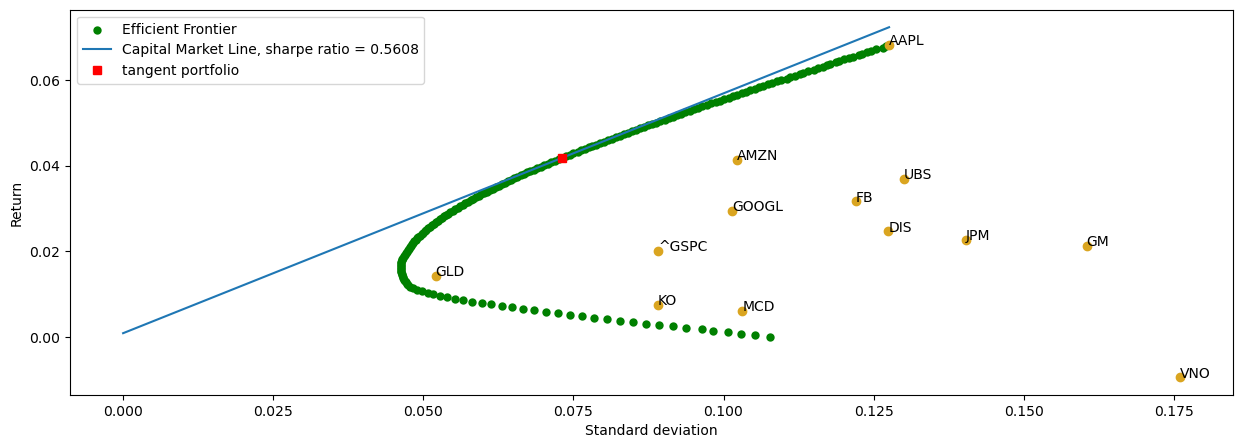

In [11]:
fig = plt.figure(figsize=(15, 5))
plt.scatter(stds, means, linewidths=0.01, color="green", label="Efficient Frontier")
for i in range(N):
    plt.plot(cp.sqrt(COV[i, i]).value, MU[i], "o", color="goldenrod")
    plt.annotate(f"{data.columns[i]}", (cp.sqrt(COV[i, i]).value, MU[i]))
plt.plot(y, CML, label=f"Capital Market Line, sharpe ratio = {max_SR.round(4)}")
plt.plot(stds[ind_SR], means[ind_SR], "rs", label="tangent portfolio")
plt.legend(loc="upper left")
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.show()

#### Weights for the tangent portfolio:

In [12]:
display(pd.DataFrame([dict(zip(data.columns, optimizer(MU, COV, means[ind_SR]).round(4)))]))

,AAPL,AMZN,GOOGL,JPM,GLD,DIS,VNO,FB,UBS,KO,MCD,^GSPC,GM
0,0.4856,0.0494,0.0002,0.0001,0.464,0.0002,0.0,0.0001,0.0003,0.0,0.0,0.0,0.0001


<a id='sec3.1'></a>
## Optimize the Sharpe ratio

Most of the time, we are not interested in the efficient frontier, but we just want to find the tangent portfolio.
An alternative is to maximize the Sharpe ratio i.e. solve the following problem:

$$  \max_{\mathbf w} \; \frac{\mathbf w^T \boldsymbol \mu - Rf }{ \sqrt{\mathbf w^T \mathbf \Sigma \, \mathbf w} } \quad \text{subject to } \quad \mathbf w^T \mathbf 1 = 1 \quad \text{and} \quad \boldsymbol w \geq 0. $$



In [13]:
weights = np.ones(N)
x0 = weights / np.sum(weights)  # initial guess

# Define the objective function (the negative Sharpe ratio)
sharpe_fun = lambda w: -(MU @ w - Rf) / np.sqrt(w.T @ COV @ w)
bounds = Bounds(0, 1)
linear_constraint = LinearConstraint(np.ones(N, dtype=int), 1, 1)
res = minimize(sharpe_fun, x0=x0, method="trust-constr", constraints=linear_constraint, bounds=bounds)

In [14]:
w_sr = res.x
print("weights = ")
display(pd.DataFrame([dict(zip(data.columns, w_sr.round(4)))]))
print("Max Sharpe ratio = ", -sharpe_fun(w_sr))
print("optimal portfolio at sigma= {} and mean={}".format(np.sqrt(w_sr @ COV @ w_sr), MU @ w_sr))

weights = 


,AAPL,AMZN,GOOGL,JPM,GLD,DIS,VNO,FB,UBS,KO,MCD,^GSPC,GM
0,0.4879,0.0486,0.0,0.0,0.4635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Max Sharpe ratio =  0.5609210027002335
optimal portfolio at sigma= 0.07327567641496409 and mean=0.04193519922155284


The weights are a bit different than before because here the maximum Sharpe ratio is more accurate. Before it was computed by grid search.

<a id='sec3.2'></a>
### Optimal weights between stocks and bond

Once we have computed the tangency portfolio, it is optimal to stay on the CML.      
Let us call $R^P$ the return of a portfolio on the CML that allocates a fraction $w$ of the initial capital to the tangency portfolio (with return $R^T$) and $1-w$ to the risk-free asset $R_f$, i.e.

$$ R^P = w R^T + (1-w) R_f = R_f + w (R^T-R_f) $$

such that 

$$ \mathbb{E}[R^P] = R_f + w (\mathbb{E}[R^T] - R_f) \quad \text{and} \quad  
\text{VAR}[R^P] = w^2 \text{VAR}[R^T]. $$

From these equations, given a desired level of expected return or variance, it is possible to calculate the optimal balance between the stocks portfolio (the tangency portfolio) and a risk free (a bond) asset.

The following function does it. Let us give a value of expected return as input and see how it works:

In [15]:
optimal_weights(MU, COV, Rf=Rf, w_max=1, desired_mean=0.02, desired_std=None)

`gtol` termination condition is satisfied.



{'Sharpe Ratio': 0.5609210027002335,
 'stock weights': array([0.4879, 0.0486, 0.    , 0.    , 0.4635, 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    ]),
 'stock portfolio': {'std': 0.073276, 'mean': 0.041935},
 'Bond + Stock weights': {'Bond': 0.5337, 'Stock': 0.4663},
 'Total portfolio': {'std': 0.03417, 'mean': 0.02}}

In [16]:
print(optimal_weights.__doc__)


    Compute the optimal weights for a portfolio containing a risk free asset and stocks.
    MU = vector of mean
    COV = covariance matrix
    Rf = risk free return
    w_max = maximum weight bound for the stock portfolio
    desired_mean = desired mean of the portfolio
    desired_std = desired standard deviation of the portfolio
    


In this function I also introduced the possibility to give an upperbound to the weights:

$$0 \leq \boldsymbol w \leq w_{max}$$

Let us try it. We can see that although there is more diversification, the introduction of this bound reduced the Sharpe ratio.

In [17]:
bounded_porf = optimal_weights(MU, COV, Rf=Rf, w_max=0.2, desired_mean=0.02, desired_std=None)
display(bounded_porf)

`gtol` termination condition is satisfied.



{'Sharpe Ratio': 0.46269725666071015,
 'stock weights': array([2.000e-01, 2.000e-01, 1.981e-01, 1.000e-04, 2.000e-01, 1.400e-03,
        0.000e+00, 4.000e-04, 1.997e-01, 1.000e-04, 0.000e+00, 1.000e-04,
        1.000e-04]),
 'stock portfolio': {'std': 0.080421, 'mean': 0.038044},
 'Bond + Stock weights': {'Bond': 0.4849, 'Stock': 0.5151},
 'Total portfolio': {'std': 0.041424, 'mean': 0.02}}

In [18]:
print("Bounded Weights = ")
display(pd.DataFrame([dict(zip(data.columns, bounded_porf["stock weights"].round(4)))]))

Bounded Weights = 


,AAPL,AMZN,GOOGL,JPM,GLD,DIS,VNO,FB,UBS,KO,MCD,^GSPC,GM
0,0.2,0.2,0.1981,0.0001,0.2,0.0014,0.0,0.0004,0.1997,0.0001,0.0,0.0001,0.0001


<a id='sec4'></a>
## Optimization with cvxpy

The code of this section follows closely the example given in the [cvxpy website](https://colab.research.google.com/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb#scrollTo=--osR2je4bDI).     
CVXPY uses a better solver, which as we will see it is much faster. It is also very easy to use.

Here I also present an alternative and equivalent formulation of the problem:

$$  \max_{\mathbf w} \; \boldsymbol \mu^T \mathbf w  - \lambda \, \mathbf w^T \mathbf \Sigma \, \mathbf w \quad \text{subject to } \quad \mathbf w^T \mathbf 1 = 1 \quad \text{and} \quad \boldsymbol w \geq 0. $$

where $\lambda > 0$ represents the risk aversion coefficient of the investor. 
The choice of a positive lambda follows the common requirement to describe a risk-averse investor.     
For $\lambda \to 0$, the investor tends to be more **risk-neutral**. For $\lambda \to \infty$ the investor is very risk-averse and the optimal portfolio converges to the **minimum variance portfolio** i.e. the portfolio with the least variance.     

From a mathematical point of view, this formulation corresponds to a problem where we want to maximize the expected return $ \boldsymbol \mu^T \mathbf w$ for a fixed variance level $v = \mathbf w^T \mathbf \Sigma \, \mathbf w$ plus the other constraints. 
We can introduce the **Lagrange multiplier** $\lambda$ such that the objective function becomes $\boldsymbol \mu^T \mathbf w  - \lambda \, (\mathbf w^T \mathbf \Sigma \, \mathbf w - v)$, which is equivalent to the initial problem (since $v$ is just a constant and does not affect the weights).

In [19]:
w = cp.Variable(N)  # weights
gamma = cp.Parameter(nonneg=True)
ret = MU @ w  # portfolio return
risk = cp.quad_form(w, COV)  # portfolio variance
objective = cp.Maximize(ret - gamma * risk)  # objective function
constraints = [cp.sum(w) == 1, w >= 0]
prob = cp.Problem(objective, constraints)

Now I replicate the results of the previous section.

I run compute the optimal portfolio for seveal values of risk aversion $\gamma$, that is equivalent to optimize for several values of portfolio standard deviations. The resulting curve is again the **efficient frontier**, where each point corresponds to a value of $\gamma$.  

In [20]:
# Compute efficient frontier.
samples = 500
std_values = np.zeros(samples)
mean_values = np.zeros(samples)
sharpe_ratio = np.zeros(samples)
gamma_vals = np.logspace(0, 4, num=samples)  # several levels of risk aversion
portfolios = []
for i in range(samples):
    gamma.value = gamma_vals[i]
    prob.solve()
    std_values[i] = cp.sqrt(risk).value
    mean_values[i] = ret.value
    sharpe_ratio[i] = (mean_values[i] - Rf) / std_values[i]
    portfolios.append(w.value)

ind_SR = np.argmax(sharpe_ratio)  # index of the maximum Sharpe Ratio
max_SR = sharpe_ratio[ind_SR]  # maximum Sharpe ratio
y = np.linspace(0, std_values.max(), samples)
CML = Rf + max_SR * y  # capital market line

#### Plot: 

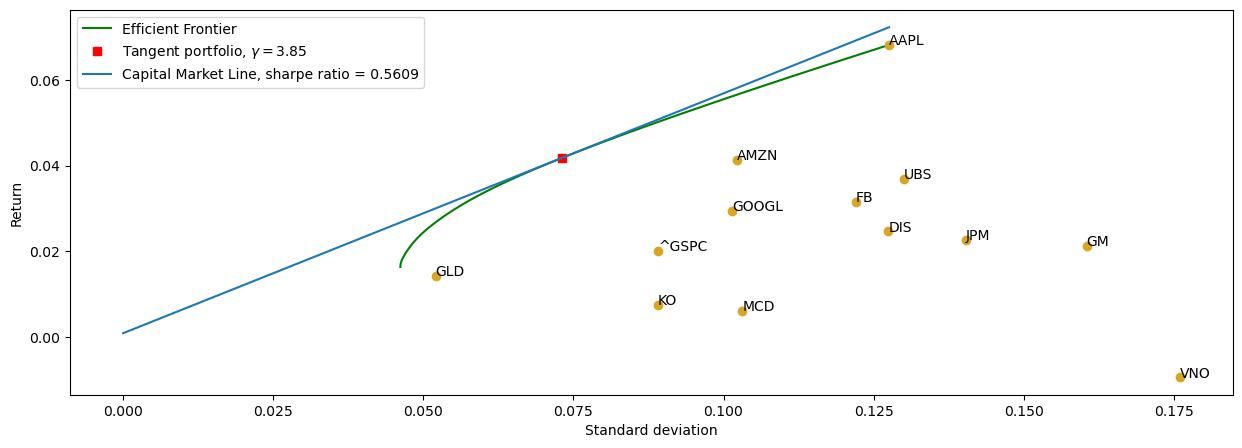

In [21]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
ax1.plot(std_values, mean_values, "g-", label="Efficient Frontier")
ax1.plot(
    std_values[ind_SR],
    mean_values[ind_SR],
    "rs",
    label=r"Tangent portfolio, $\gamma = {:.2f}$".format(gamma_vals[ind_SR]),
)
ax1.plot(y, CML, label=f"Capital Market Line, sharpe ratio = {max_SR.round(4)}")
for i in range(N):
    ax1.plot(cp.sqrt(COV[i, i]).value, MU[i], "o", color="goldenrod")
    ax1.annotate(f"{data.columns[i]}", (cp.sqrt(COV[i, i]).value, MU[i]))
ax1.legend(loc="upper left")
ax1.set_xlabel("Standard deviation")
ax1.set_ylabel("Return")
plt.show()

In [22]:
print("Weights:")
display(pd.DataFrame([dict(zip(data.columns, portfolios[ind_SR].round(5)))]))
print("gamma=", gamma_vals[ind_SR])
print("Sharpe Ratio = ", max_SR)
print("Standard Deviation and mean of the portfolio", std_values[ind_SR].round(6), mean_values[ind_SR].round(6))

Weights:


,AAPL,AMZN,GOOGL,JPM,GLD,DIS,VNO,FB,UBS,KO,MCD,^GSPC,GM
0,0.48551,0.04903,-0.0,-0.0,0.46546,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


gamma= 3.8474265772585037
Sharpe Ratio =  0.5609197942924549
Standard Deviation and mean of the portfolio 0.073067 0.041818


<a id='sec5'></a>
## Probability density of the tangency portfolio

What if we want to compute some probabilities? For instance the probability of losing money e.g. $\mathbb{P}(R^P < x)$ ?

Well, we do not have a closed form for the density of the portfolio. Since each $R^i$ is log-normal, then $\sum_i w_i R^i$ is not a log-normal.      
You can see here [wiki-related distribution](https://en.wikipedia.org/wiki/Log-normal_distribution#Related_distributions) that the sum of independent LN random variables is approximately log-normal, but not exactly log-normal. In our case the variables are correlated.

We can use Monte Carlo to simulate many LN linear returns and compute the empirical density of the portfolio.
It is convenient, in order to obtain a smooth density, to work with the **Gaussian Kernel density estimation** [KDE](Kernel density estimation). 

Let us generate some multivariate log-normal (LN) random variables $R_T = \frac{S_0e^{X_T}-S_0}{S_0}$, starting from the knowledge of the multivariate normal random variables $X_T$. We previously computed the monthly mean and covariance of $X_T$.

In [23]:
np.random.seed(seed=42)
LN_ret = np.exp(ss.multivariate_normal.rvs(mean=mu_log, cov=cov_log, size=50000)) - 1

In [24]:
def plot_prob(LN_ret, w, lower_value):
    """Probability density of the optimal portfolio
    LN_ret = simulated log-returns. MxN matrix
    w = weights vector Nx1 vector
    lower_value = the maximum loss we are considering
    """
    if LN_ret.shape[1] != w.shape[0]:
        raise ValueError

    MU_simul = LN_ret.mean(axis=0)  # mean of the linear returns (equal to MU)
    COV_simul = np.cov(LN_ret, rowvar=False)  # covariance matrix   (equal to COV)
    Opt_portfolios = LN_ret @ w  # portfolio linear returns
    mu_port = MU_simul @ w  # portfolio mean
    sig_port = np.sqrt(w @ COV_simul @ w)  # portfolio standard deviation

    x = np.linspace(Opt_portfolios.min(), Opt_portfolios.max(), 500)
    kde = ss.gaussian_kde(Opt_portfolios)
    normal = ss.norm(loc=mu_port, scale=sig_port)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(
        x,
        kde.evaluate(x),
        color="salmon",
        label="KDE, loss prob={:.4f}".format(kde.integrate_box_1d(-np.inf, lower_value)),
    )
    plt.plot(x, normal.pdf(x), label="Normal, loss prob={:.4f}".format(normal.cdf(lower_value)))
    plt.axvline(x=lower_value, color="grey", linestyle="--", lw=2, label="Maximum loss")
    plt.axvline(x=mu_port, color="green", linestyle="--", lw=1, label="Portfolio mean return")
    plt.axvline(x=mu_port - sig_port, color="orange", linestyle="--", lw=1, label=r"$\pm$ standard deviation")
    plt.axvline(x=mu_port + sig_port, color="orange", linestyle="--", lw=1)
    plt.title("Probability density of the portfolio returns")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend(loc="upper right")
    plt.show()

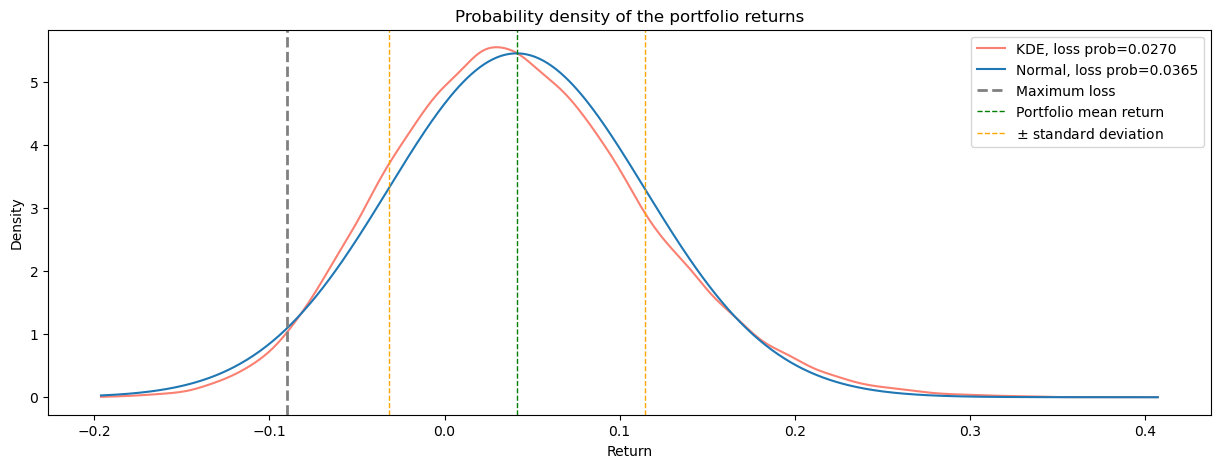

In [25]:
plot_prob(LN_ret=LN_ret, w=w_sr, lower_value=-0.09)

#### Comment: 

- We can see that the two curves are not so different. This is because 1 month is still a small interval of time, and therefore the linear returns are approximately distributed like the log-returns (Normally distributed) and the sum of Normal distributed random variables is Normal. 
For a bigger time interval e.g. 1 year, the two curves become very very different.

- The loss probability in the plot is the probability of losing more than the Maximum loss value i.e. $\mathbb{P}(R^P < -0.9)$

<a id='sec6'></a>
## Short positions - closed formula

If are allowed to take short positions, we can remove the bound $\boldsymbol w \geq 0$ and the problem becomes:

$$  \min_{\mathbf w} \; \mathbf w^T \mathbf \Sigma \, \mathbf w \quad \text{subject to } \quad \boldsymbol \mu^T \mathbf w = \mu^P, \quad \mathbf w^T \mathbf 1 = 1. $$

Following [3] we can compute the weights and the efficient frontier in closed form.

We can define the following new variables: 

$$ \boldsymbol{\Omega} = \boldsymbol{\Sigma}^{-1}, \quad A = \boldsymbol{1}^T \boldsymbol{\Omega} \boldsymbol{\mu}, 
\quad B = \boldsymbol{\mu}^T \boldsymbol{\Omega} \boldsymbol{\mu}, \quad C = \boldsymbol{1}^T \boldsymbol{\Omega} \boldsymbol{1}, \quad D = B\,C - A^2. 
$$

The weights have the following **closed expression**:

$$ \boldsymbol{w} = \frac{\mu^P \boldsymbol{\Omega} \bigl(C \boldsymbol{\mu} - A \bigr) + 
\boldsymbol{\Omega} \bigl( B-A\boldsymbol{\mu} \bigr) }{D}.  $$

The **efficient frontier** is a **parabola** with the following equation:

$$ \bigl(\sigma^P \bigr)^2 = \frac{ C \bigl(\mu^P \bigr)^2 - 2A \mu^P + B}{D}. $$

It is good to check that the covariance matrix is full rank before the inversion.

In [26]:
print("The rank of the covariance matrix is:", np.linalg.matrix_rank(COV))
print("The shape of the covariance matrix is:", COV.shape)

The rank of the covariance matrix is: 13
The shape of the covariance matrix is: (13, 13)


In [27]:
Omega = np.linalg.inv(COV)
A = np.ones(N) @ Omega @ MU
B = MU @ Omega @ MU
C = Omega.sum()
D = B * C - A**2

In [28]:
target_mu = 0.1
weights_th = (target_mu * Omega @ (C * MU - A) + Omega @ (B - MU * A)) / D  # theoretical weights

#### Theoretical weights:

In [29]:
display(pd.DataFrame([dict(zip(data.columns, weights_th.round(4)))]))

,AAPL,AMZN,GOOGL,JPM,GLD,DIS,VNO,FB,UBS,KO,MCD,^GSPC,GM
0,1.2458,0.3685,0.5282,0.5597,0.9733,0.1442,-0.2223,-0.272,0.4089,0.1547,-0.1562,-2.9257,0.193


#### Numerical weights:

In [30]:
display(pd.DataFrame([dict(zip(data.columns, optimizer(MU, COV, target_mu, False).round(4)))]))

,AAPL,AMZN,GOOGL,JPM,GLD,DIS,VNO,FB,UBS,KO,MCD,^GSPC,GM
0,1.2458,0.3685,0.5282,0.5597,0.9733,0.1442,-0.2223,-0.272,0.4089,0.1547,-0.1562,-2.9257,0.193


#### Let us compute the efficient frontier

In [31]:
samples = 50
means = np.linspace(-0.1, 0.17, samples)  # vector of target expected returns
stds = np.zeros_like(means)

for i, mn in enumerate(means):
    w_opt = optimizer(MU, COV, mn, OnlyLong=False)  # optimal weights
    stds[i] = np.sqrt(w_opt @ COV @ w_opt)  # std of the portfolio

#### Plot

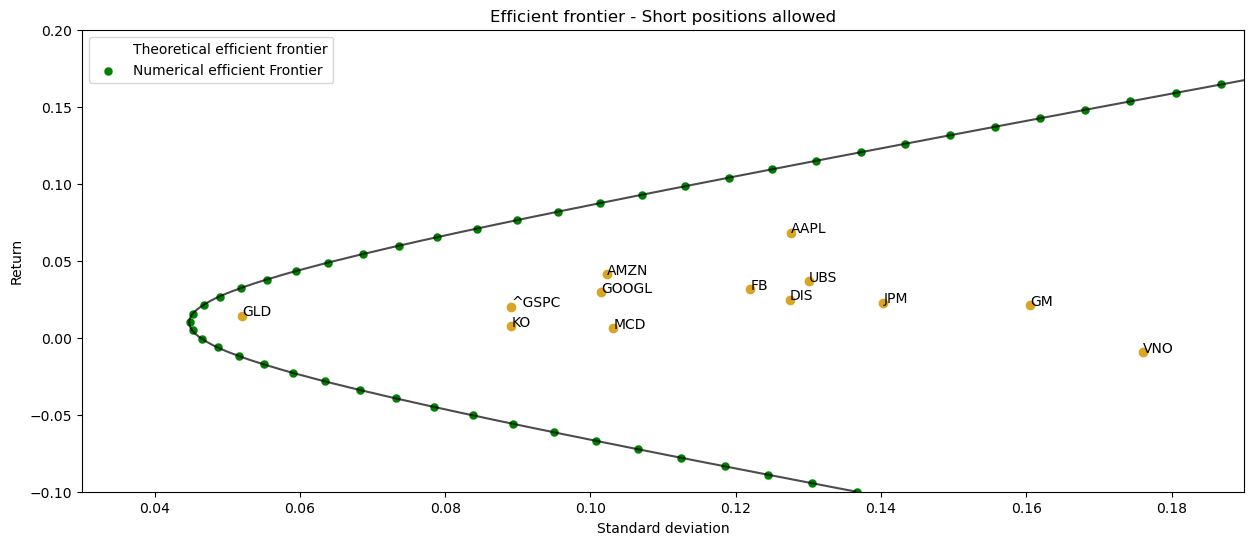

In [32]:
fig = plt.figure(figsize=(15, 6))
y = np.linspace(-0.1, 0.2, 400)
x = np.linspace(0, 0.23, samples)
y, x = np.meshgrid(x, y)
CS = plt.contour(y, x, y**2 - (C * x**2 - 2 * A * x + B) / D, [0], colors="k", alpha=0.7)
plt.clabel(CS, inline=1, fontsize=10)
CS.collections[0].set_label("Theoretical efficient frontier")
plt.scatter(stds, means, linewidths=0.1, color="green", label="Numerical efficient Frontier")
for i in range(N):
    plt.plot(cp.sqrt(COV[i, i]).value, MU[i], "o", color="goldenrod")
    plt.annotate(f"{data.columns[i]}", (cp.sqrt(COV[i, i]).value, MU[i]))
plt.xlim([0.03, 0.19])
plt.legend(loc="upper left")
plt.title("Efficient frontier - Short positions allowed")
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.show()

## References

[1] Attilio Meucci (2005) *Risk and asset allocation*. 

[2] D. Ruppert, D. Matteson (2015) *Statistics and Data analysis for financial engineering*

[3] Robert Merton (1970) *An analytical derivation of the efficient portfolio frontier*